In [1]:
import numpy as np
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
from torchvision import transforms as transforms
from torchsummary import summary
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(50)
if device == 'cuda':
    torch.cuda.manual_seed_all(50)

In [ ]:
! ls

In [3]:
train_ds = torchvision.datasets.ImageFolder(root="../Lab_05_(inception)/baby_data/train", transform=transforms.ToTensor())
val_ds = torchvision.datasets.ImageFolder(root="../Lab_05_(inception)/baby_data/val", transform=transforms.ToTensor())
test_ds = torchvision.datasets.ImageFolder(root="../Lab_05_(inception)/baby_data/test", transform=transforms.ToTensor())

In [4]:
def get_Mean(data):
    RGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in data]
    mean_R = np.mean([m[0] for m in RGB])
    mean_G = np.mean([m[1] for m in RGB])
    mean_B = np.mean([m[2] for m in RGB])

    return mean_R, mean_G, mean_B


def get_Std(data):
    RGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in data]
    std_R = np.mean([s[0] for s in RGB])
    std_G = np.mean([s[1] for s in RGB])
    std_B = np.mean([s[2] for s in RGB])

    return std_R, std_G, std_B

In [5]:
# RGB 평균 구하기
train_meanR, train_meanG, train_meanB = get_Mean(train_ds)
val_meanR, val_meanG, val_meanB = get_Mean(val_ds)
test_meanR, test_meanG, test_meanB = get_Mean(test_ds)

# RGB 표준편차 구하기
train_stdR, train_stdG, train_stdB = get_Std(train_ds)
val_stdR, val_stdG, val_stdB = get_Std(val_ds)
test_stdR, test_stdG, test_stdB = get_Std(test_ds)

In [6]:
print("train Mean : ", train_meanR, train_meanG, train_meanB)
print("train Std : ", train_stdR, train_stdG, train_stdB)

train Mean :  0.20443186 0.622418 0.4943464
train Std :  0.10832494 0.10485981 0.071922004


In [7]:
def get_trans(width, height, m_r, m_g, m_b, s_r, s_g, s_b):
    transformation = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize((width, height)),
        transforms.Normalize([m_r, m_g, m_b], [s_r, s_g, s_b]),
    ])
    return transformation

In [8]:
train_transformation = get_trans(224, 224, train_meanR, train_meanG, train_meanB,
                                 train_stdR, train_stdG, train_stdB)

val_transformation = get_trans(224, 224, val_meanR, val_meanG, val_meanB,
                               val_stdR, val_stdG, val_stdB)

test_transformation = get_trans(224, 224, test_meanR, test_meanG, test_meanB,
                                test_stdR, test_stdG, test_stdB)

train_ds.transform = train_transformation
val_ds.transform = val_transformation
test_ds.transform = test_transformation

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

classes = ('bgs', 'crying')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 499, 145])


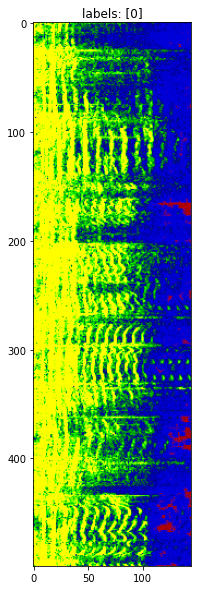

In [9]:
# display sample images
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels: ' + str(y))


np.random.seed(0)
torch.manual_seed(0)

grid_size = 1
rnd_inds = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = torchvision.utils.make_grid(x_grid, nrow=5, padding=0)

# call helper function
plt.figure(figsize=(10, 10))
show(x_grid, y_grid)

print(x_grid.shape)

In [10]:
class BasicBlock(nn.Module):
    def __init__(self,input_ch,output_ch,stride=1):
        super().__init__()
        
        self.basick_layer = nn.Sequential(
            nn.Conv2d(input_ch, output_ch, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(),
            nn.Conv2d(output_ch, output_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_ch),
        )
        
        self.shortcut = nn.Sequential()
        
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_ch,output_ch,kernel_size=1,stride=2),
                nn.BatchNorm2d(output_ch)
            )
        
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.basick_layer(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [11]:
class Resnet34(nn.Module):
    def __init__(self, block,num_classes=2, init_weight=True):
        super().__init__()
        self.in_channel = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_x = self.make_block(block, out_channel=64, num_block=3, stride=1)
        self.conv3_x = self.make_block(block, out_channel=128, num_block=4, stride=2)
        self.conv4_x = self.make_block(block, out_channel=256, num_block=6, stride=2)
        self.conv5_x = self.make_block(block, out_channel=512, num_block=3, stride=2)
        self.avgpool1 = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512,num_classes)
        
        if init_weight:
            self.weights_initialize()

    def make_block(self,block, out_channel, num_block, stride):
        stride_list = [stride] + [1] * (num_block - 1)
        layer = []
        for i in stride_list:
            layer.append(block(self.in_channel,out_channel,i))
            self.in_channel = out_channel
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool1(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

    def weights_initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model = Resnet34(BasicBlock).to(device)
print(model)

Resnet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): BasicBlock(
      (basick_layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (basick_layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [ ]:
a = torch.rand(1,3,145,499)
b = nn.Conv2d(3,64,kernel_size=7, stride=2, padding=3)
print(b(a).shape)

print(model(a))

In [14]:
summary(model, input_size=(3, 145, 499), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 73, 250]           9,472
       BatchNorm2d-2          [-1, 64, 73, 250]             128
              ReLU-3          [-1, 64, 73, 250]               0
         MaxPool2d-4          [-1, 64, 37, 125]               0
            Conv2d-5          [-1, 64, 37, 125]          36,928
       BatchNorm2d-6          [-1, 64, 37, 125]             128
              ReLU-7          [-1, 64, 37, 125]               0
            Conv2d-8          [-1, 64, 37, 125]          36,928
       BatchNorm2d-9          [-1, 64, 37, 125]             128
             ReLU-10          [-1, 64, 37, 125]               0
       BasicBlock-11          [-1, 64, 37, 125]               0
           Conv2d-12          [-1, 64, 37, 125]          36,928
      BatchNorm2d-13          [-1, 64, 37, 125]             128
             ReLU-14          [-1, 64, 

In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = CosineAnnealingLR(opt, T_max=10, eta_min=0.00001)


def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


def loss_epoch(model, loss_func, dataset_dl, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


def train_val(model, params):
    num_epochs = params["num_epochs"] 
    loss_func = params["loss_func"] 
    opt = params["optimizer"] 
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Message : Copied best model')

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        lr_scheduler.step()

        print('train loss: %.6f, val loss: %.6f, val_accuracy: %.2f, time: %.4f min' % (train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history


In [16]:
# definc the training parameters
params_train = {
    'num_epochs': 100,
    'optimizer': opt,
    'loss_func': loss_func,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights.pt',
}

# create the directory that stores weights.pt


def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')


createFolder('./models')


In [17]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.001
Message : Copied best model
train loss: 0.104261, val loss: 0.063139, val_accuracy: 98.33, time: 0.8131 min
----------
Epoch 1/99, current lr=0.0009757729755661011
train loss: 0.040799, val loss: 0.149666, val_accuracy: 93.00, time: 1.6205 min
----------
Epoch 2/99, current lr=0.000905463412215599
train loss: 0.021441, val loss: 0.123466, val_accuracy: 95.33, time: 2.4282 min
----------
Epoch 3/99, current lr=0.0007959536998847742
Message : Copied best model
train loss: 0.018828, val loss: 0.022213, val_accuracy: 99.00, time: 3.2757 min
----------
Epoch 4/99, current lr=0.000657963412215599
train loss: 0.010707, val loss: 0.042744, val_accuracy: 99.00, time: 4.1468 min
----------
Epoch 5/99, current lr=0.000505
train loss: 0.004161, val loss: 0.067243, val_accuracy: 96.33, time: 5.0175 min
----------
Epoch 6/99, current lr=0.0003520365877844011
train loss: 0.004832, val loss: 0.068890, val_accuracy: 97.67, time: 5.8860 min
----------
Epoch 7/99, current lr=

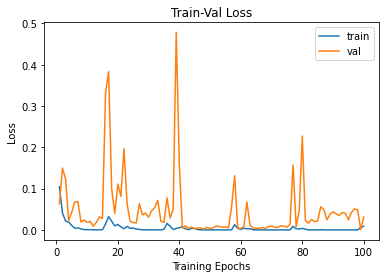

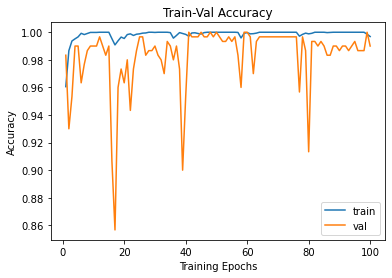

In [19]:
# Train-Validation Progress
num_epochs = params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [29]:
loss_history = {'test': []}
metric_history = {'test': []}

model.eval()
with torch.no_grad():
    test_loss, test_metric = loss_epoch(model, loss_func, test_dl)
    loss_history['test'].append(test_loss)
    metric_history['test'].append(test_metric)

print('test_accuracy: %.2f '% (100*test_metric))


AttributeError: '_IncompatibleKeys' object has no attribute 'eval'